#### 匯入模型與初始化

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
# 設定中文字型為微軟正黑體 (Microsoft JhengHei)
rcParams['font.family'] = 'Microsoft JhengHei'

import cv2
import mmcv
from mmseg.apis import inference_model, init_model, show_result_pyplot
import numpy as np
import torch

# 讀取模型設定與權重
config_file = '../mmSeg_trained_models/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'
checkpoint_file = '../mmSeg_trained_models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

#### 全局變數

In [6]:
MODEL = init_model(config_file, checkpoint_file, device='cuda:0')

# 類別名稱
CLASSES = MODEL.dataset_meta['classes']
print(CLASSES)

# 顏色對應 (可選)
PALETTE = MODEL.dataset_meta.get('palette', None)
print(PALETTE)

# 定義人造物與自然物
HUMAN_MADE = {'road','sidewalk','building','wall','fence','pole',
            'traffic light','traffic sign','car','truck','bus','train',
            'motorcycle','bicycle'}
NATURE = {'vegetation','terrain','sky','person','rider'}

c:\Users\yutse\anaconda3\envs\torch-gpu\lib\site-packages\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
c:\Users\yutse\anaconda3\envs\torch-gpu\lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ../mmSeg_trained_models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
('road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle')
[[128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32]]


#### 定義視覺化功能

In [7]:
def compare_images(*images, titles=None):
    """
    比較多張影像，並可自訂標題。
    
    Args:
        *images: 任意數量的影像，BGR 格式 (mmcv.imread 讀取)
        titles: 可選，list of str，對應每張影像的標題
                如果未提供，預設依序為 ['原圖', '語意分割', '後處理', ...]
    """
    n = len(images)
    if titles is None:
        # 預設標題，依照影像數量生成
        default_titles = ['原圖', '語意分割', '後處理']
        titles = default_titles[:n] + [f'圖像{i+1}' for i in range(n - len(default_titles))]
    
    plt.figure(figsize=(5*n, 5))
    
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        # 如果是 BGR，轉 RGB
        if isinstance(img, np.ndarray) and img.shape[-1] == 3:
            plt.imshow(mmcv.bgr2rgb(img))
        else:
            plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
def semantic_to_instance_masks(seg_map: np.ndarray, target_class: int, min_area=50):
    """
    從語意分割結果中提取某一類別的 instance mask
    seg_map: HxW (int) 語意標籤圖
    target_class: 要提取的類別 id
    min_area: 過濾小面積雜訊
    return: instance_masks (list of binary mask), labeled_map (HxW, 每個像素標記對應的 instance id)
    """
    binary_mask = (seg_map == target_class).astype(np.uint8) * 255
    
    # 找 connected components
    num_labels, labels = cv2.connectedComponents(binary_mask)
    
    instance_masks = []
    instance_id_map = np.zeros_like(seg_map, dtype=np.int32)
    
    instance_id = 1
    for label in range(1, num_labels):  # 0 是背景
        mask = (labels == label).astype(np.uint8)
        if cv2.countNonZero(mask) >= min_area:
            instance_masks.append(mask)
            instance_id_map[mask == 1] = instance_id
            instance_id += 1

    return instance_masks, instance_id_map

#### 定義單張圖片處理邏輯

In [9]:
def process_single_frame(frame, titles=None, show_comapre=False, instance_class_id=8):
    """
    對單張影像進行語意分割、重新分類、Instance Segmentation（指定類別），並顯示結果。
    
    Args:
        frame (np.ndarray): 已讀取的影像 BGR 或 RGB 陣列
        titles (list, optional): 顯示標題列表
        show_comapre (bool): 是否顯示對比圖
        instance_class_id (int): 要做 instance segmentation 的類別 id（默認 8 = vegetation）
    
    Returns:
        img_rgb (np.ndarray): 原圖 RGB
        seg_classified (np.ndarray): 人造/自然分類結果
        ratios (tuple): (human_ratio, nature_ratio)
        vis_instance (np.ndarray): Instance segmentation 可視化圖
    """

    if titles is None:
        titles = ['原圖', '語意分割', '後處理']

    # BGR -> RGB
    img_rgb = mmcv.bgr2rgb(frame) if frame.shape[2] == 3 else frame

    # 推論
    result = inference_model(MODEL, img_rgb)

    # 取得分割索引
    if hasattr(result, 'pred_sem_seg'):
        seg_map = result.pred_sem_seg
        if hasattr(seg_map, 'data'):
            seg_map = seg_map.data
        if isinstance(seg_map, torch.Tensor):
            seg_map = seg_map.squeeze().cpu().numpy()
        if seg_map.ndim == 3:
            seg_map = seg_map.argmax(axis=0)
        seg_map = seg_map.astype(np.int64)
    else:
        raise ValueError("SegDataSample 沒有 pred_sem_seg 屬性")

    # 人造 / 自然重新分類
    seg_classified = np.zeros_like(seg_map, dtype=np.int64)
    for i, cls in enumerate(CLASSES):
        mask = (seg_map == i)
        if cls in HUMAN_MADE:
            seg_classified[mask] = 1
        else:
            seg_classified[mask] = 2

    # 語意分割顏色映射
    seg_colors = np.array([
        [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
        [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
        [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
        [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
        [0, 80, 100], [0, 0, 230], [119, 11, 32]
    ], dtype=np.uint8)

    processed_colors = np.zeros_like(seg_colors)
    for i, cls in enumerate(CLASSES):
        if cls in HUMAN_MADE:
            processed_colors[i] = [255, 0, 0]
        else:
            processed_colors[i] = [0, 255, 0]

    seg_rgb = seg_colors[seg_map]
    seg_processed_rgb = processed_colors[seg_map]

    # Instance segmentation for specific class
    instance_masks, instance_id_map = semantic_to_instance_masks(seg_map, target_class=instance_class_id)
    vis_instance = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for idx, mask in enumerate(instance_masks):
        color = np.random.randint(0, 255, (3,), dtype=np.uint8)
        vis_instance[mask == 1] = color

    # 顯示結果
    if show_comapre:
        compare_images(img_rgb, seg_rgb, seg_processed_rgb, titles=titles)
        compare_images(img_rgb, vis_instance, titles=["原圖", f"Instance Segmentation (class {instance_class_id})"])

    # 計算人造/自然比例
    label_type = np.array([0 if cls in HUMAN_MADE else 1 for cls in CLASSES])
    human_pixels = np.sum(label_type[seg_map] == 0)
    nature_pixels = np.sum(label_type[seg_map] == 1)
    total_pixels = seg_map.size
    human_ratio = human_pixels / total_pixels
    nature_ratio = nature_pixels / total_pixels
    if show_comapre:
        print(f"人造物比例: {human_ratio:.3f}")
        print(f"自然物比例: {nature_ratio:.3f}")
        print(f"{CLASSES[instance_class_id]} instance 數量: {len(instance_masks)}")

    return img_rgb, seg_classified, (human_ratio, nature_ratio), vis_instance

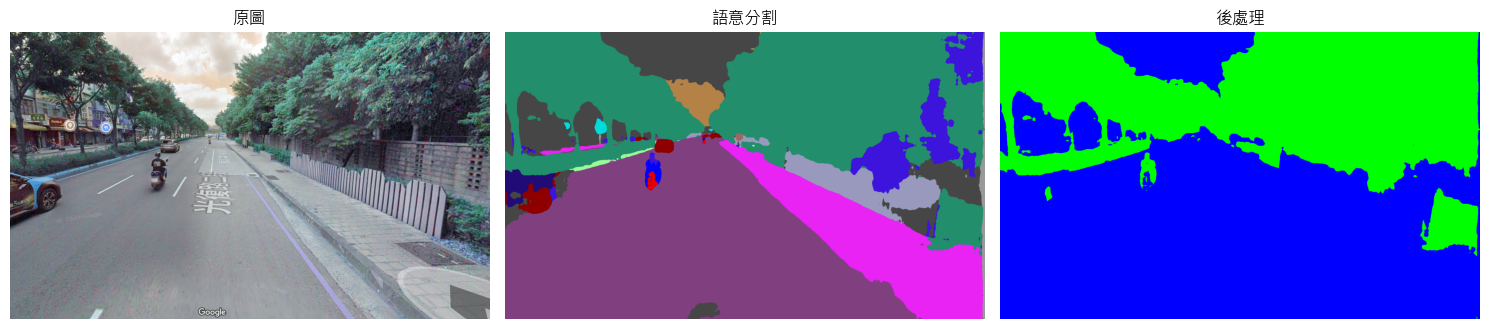

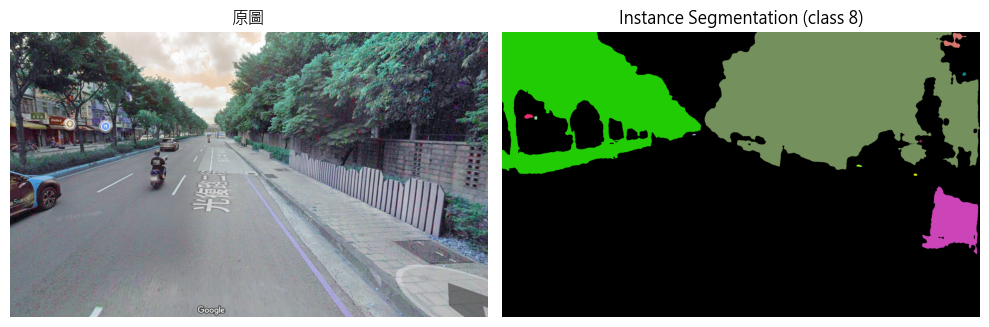

人造物比例: 0.607
自然物比例: 0.393
vegetation instance 數量: 11


In [ ]:

# 測試影像
img = mmcv.imread('../dataset/S__61571147.jpg')
result = process_single_frame(img, show_comapre=True)

#### 測試影片

In [11]:
# 處理影片
human_ratio_list = []
nature_ratio_list = []
video = mmcv.VideoReader('dataset/0.0-30.0.mp4')
for i, frame in enumerate(video):
    if i % 1 == 0:  # 每100幀處理一次
        print(f"第{i}/{len(video)}偵畫面 處理中...", end='\r')
        img_rgb, seg_classified, (human_ratio, nature_ratio),_ = process_single_frame(frame, show_comapre=False)
        human_ratio_list.append(human_ratio)
        nature_ratio_list.append(nature_ratio)

# 繪製比例隨時間變化
plt.figure(figsize=(12,5))
plt.plot(human_ratio_list, label='人造物比例', color='red')
plt.plot(nature_ratio_list, label='自然物比例', color='green')
plt.xlabel('偵數 (每100幀)')
plt.ylabel('比例')
plt.title('影片中人造物與自然物比例變化')
plt.legend()
plt.grid(True)
plt.show()

FileNotFoundError: Video file not found: dataset/0.0-30.0.mp4